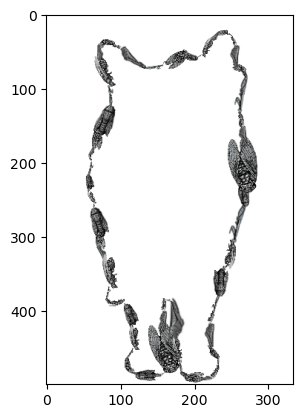

In [92]:
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from PIL import Image
from rembg import remove

DRAW_EDGE_FIGURE = 1
GREEN = (0, 255, 0)
THCK = 1

coef_adj_scale = [
    1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
    0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
    1.0, 1.0, 1.0,
]

part_insect_name = [
    "butterfly1","butterfly2","butterfly3","butterfly4","caterpillar1","caterpillar2",
    "cicada1","cicada2","grasshopper1","grasshopper2","hornet1","hornet2",
    "jewel","leaf","mantis","pill","snail","weevil"
]

line_insect_name = [
    'mantis10',"cicada1","cicada2","grasshopper","hornet",
]

def split_points(start_point, end_point):
    # 1/2 と 1/2 の位置で分割
    mid_point1 = [start_point[0] + (end_point[0] - start_point[0]) / 2, 
                  start_point[1] + (end_point[1] - start_point[1]) / 2]
    
    mid_point2 = [start_point[0] + 2 * (end_point[0] - start_point[0]) / 2, 
                  start_point[1] + 2 * (end_point[1] - start_point[1]) / 2]
    
    return mid_point1, mid_point2

def calc_angle_from_points(start_point, end_point):
    # 座標の差を求める
    dx = end_point[0] - start_point[0]
    dy = end_point[1] - start_point[1]
    
    # atan2関数を使って角度を計算（ラジアン）
    angle_rad = math.atan2(dy, dx)
    
    # ラジアンを度に変換
    angle_deg = math.degrees(angle_rad)
    
    #小数点以下切り捨て
    angle_deg_t = math.floor(angle_deg)

    return angle_deg_t

def rotate_image(img, angle, center=None, scale=1.0):
    (h, w) = img.shape[:2]
    
    if center is None:
        center = (w // 2, h // 2)
        
    # 回転行列を生成
    rot_mat = cv2.getRotationMatrix2D(center, angle, scale)
    rotated_img = cv2.warpAffine(img, rot_mat, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0, 0))
    
    return rotated_img

def calc_angle(start_p, end_p):
    delta_x, delta_y = calc_delta(start_p, end_p)
    angle_radians = math.atan2(delta_y, delta_x)
    angle_degrees = math.degrees(angle_radians)
    return (angle_degrees + 90) % 360

def calc_delta(start_p, end_p):
    delta_x = end_p[0] - start_p[0]
    delta_y = end_p[1] - start_p[1]
    return delta_x, delta_y

def calc_distance(start_p, end_p):
    delta_x, delta_y = calc_delta(start_p, end_p)
    return int(math.sqrt(delta_x**2 + delta_y**2))

def calc_midpoint(start_p, end_p):
    return (start_p[0] + end_p[0]) // 2, (start_p[1] + end_p[1]) // 2

def calculation_element(mask,COLOR):
    contour_part = get_largest_contour(mask)
    center_part, size_part, angle_part = cv2.minAreaRect(contour_part)
    area_part = cv2.contourArea(contour_part, False)
    list_similarity = []
    list_contour_insect = []
    for i in part_insect_name:
        insect_mask = cv2.imread("image/senga/mask/"+i+"_mask.png",0)
        contour_insect = get_largest_contour(insect_mask)
        list_contour_insect.append(contour_insect)
        ret = cv2.matchShapes(contour_part, contour_insect, 1, 0.0)
        list_similarity.append(ret)
    value_most_similar = min(list_similarity)
    index_most_similar = list_similarity.index(value_most_similar)
    # 類似昆虫画像輪郭より面積を求める
    contour_most_similar = list_contour_insect[index_most_similar]
    area_insect_most_similar = cv2.contourArea(contour_most_similar, False)
    area_ratio = area_part / area_insect_most_similar
    sqrt_area_ratio = math.sqrt(area_ratio) * coef_adj_scale[index_most_similar]
    center_insect, size_insect, angle_insect = cv2.minAreaRect(contour_most_similar)
    if COLOR ==0:
        insect_file_path = "image/senga/black_part/"+part_insect_name[index_most_similar]+".png"
    else:
        insect_file_path = "image/senga/white_part/"+part_insect_name[index_most_similar]+".png"
    insect_img = cv2.imread(insect_file_path,cv2.IMREAD_UNCHANGED)
    angle_for_affin = (angle_insect - angle_part  + 360) % 360
    width_ins_sim = insect_img.shape[1]
    height_ins_sim = insect_img.shape[0]
    size_ins_sim = (width_ins_sim, height_ins_sim)
    center_ins_sim = (width_ins_sim / 2, height_ins_sim / 2)
    rot_mtx = cv2.getRotationMatrix2D(center_ins_sim, angle_for_affin, sqrt_area_ratio)
    element_img = cv2.warpAffine(insect_img, rot_mtx, size_ins_sim, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    return element_img

def cascade(image,filename):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    width = image.shape[1]
    height = image.shape[0]

    cascade = cv2.CascadeClassifier("haarcascade_frontalcatface_extended.xml")
    #顔を検出
    list = cascade.detectMultiScale(image, minSize=(50, 50))
    make_part_mask(list,filename,width,height)

def division(aggregate_mask,filename):
    division = [4,9,16]
    for idx,pi in enumerate(division):
        os.mkdir("image/aggregate/"+filename+"/"+str(pi))
        width = aggregate_mask.shape[1]
        height = aggregate_mask.shape[0]
        division_num = int(np.sqrt(pi))
        division_width = int(width/division_num)
        division_height = int(height/division_num)
        start_x = 0
        start_y = 0
        for i in range(0,pi):
            division_mask,end_x = make_division_mask(aggregate_mask,start_x,start_y,division_width,division_height)
            cv2.imwrite("image/aggregate/"+filename+"/"+str(pi)+"/"+str(pi)+"_"+str(i+1)+"_mask.png",division_mask)
            if end_x+division_width > width:
                start_x = 0
                start_y = start_y+division_height
            else:
                start_x = start_x+division_width

def get_largest_contour(mask):
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = []
    num_points = 0
    for cnt in contours:
        if len(cnt) > num_points:
            num_points = len(cnt)
            largest_contour = cnt

    return largest_contour

def get_point(filename):
    with open('image/aggregate/'+filename+'/part.txt') as f:
        point = [x.rstrip() for x in f.readlines()]
    face = [int(point[0]), int(point[1])]
    left = [int(point[2]), int(point[3])]
    right = [int(point[4]), int(point[5])]
    nose = [int(point[6]), int(point[7])]

    point_part = [face,left,right,nose]
    return point_part

def make_aggregate_mask(image,filename): #集合体マスクの作成
    remove_image = remove(image)
    remove_image = cv2.cvtColor(remove_image, cv2.COLOR_BGR2RGB) #画像の色をmatplotlibに合わせて変換(BGR->RGB)
    ret,aggregate_mask = cv2.threshold(remove_image, 0, 255, cv2.THRESH_BINARY) #2値化

    #背景画像作成
    height,width = aggregate_mask.shape[:2]
    back_image = np.zeros((height, width, 3),np.uint8)
    back_image += 255

    cv2.imwrite("image/aggregate/"+filename+"/aggregate_mask.png",aggregate_mask)
    cv2.imwrite("image/aggregate/"+filename+"/back_image.png",back_image)

    return aggregate_mask,back_image

def make_division_mask(aggregate_mask,start_x,start_y,division_width,division_height):
    end_x = start_x+division_width
    end_y = start_y+division_height
    blank = np.zeros((aggregate_mask.shape[0],aggregate_mask.shape[1],3),np.uint8)
    mask = blank.copy()
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2RGBA)
    #目標範囲のマスクを生成
    for i in range(start_y,end_y):
        for j in range(start_x,end_x):
            mask[i][j] = 255
    division_mask = cv2.bitwise_and(aggregate_mask,mask)
    return division_mask,end_x

def make_part_mask(list,filename,width,height):
    x = list[0][0]
    y= list[0][1]
    w = list[0][2]
    h = list[0][3]
    face = [int(x+w/2) , int(y+h/2)]
    left = [int(x+w/4) , int(y+h/3)]
    right = [int(x+w/4*3) , int(y+h/3)]
    nose = [int(x+w/2) , int(y+h/2)]
    part = [face,left,right,nose]
    part_name=["face","lefteye","lefteye2","eye","eye2","nose"]
    os.mkdir("image/aggregate/"+filename+"/part")
    with open("image/aggregate/"+filename+"/part.txt",mode = "w") as f:
        for i,pi in enumerate(part):
            f.write(str(pi[0])+'\n')
            f.write(str(pi[1])+'\n')
    for i,pi in enumerate(part_name):
        basic = cv2.imread("image/basic/basic_"+str(pi)+"_mask.png",0)
        part_mask = cv2.resize(basic,(w,h))
        cv2.imwrite("image/aggregate/"+filename+"/part/"+str(pi)+"_mask.png",part_mask)
    for i in range(1,9):
        basic = cv2.imread("image/basic/basic_mouse"+str(i)+"_mask.png",1)
        part_mask = cv2.resize(basic,(w,h))
        blank = np.zeros((height, width, 3), np.uint8)
        blank[y:(y+h),x:(x+w)] = part_mask
        cv2.imwrite('image/aggregate/'+filename+'/part/mouse'+str(i)+'_mask.png', blank)        

def place_insect_along_line(back_img, insect_start_point, insect_end_point, idx,COLOR):
    #if DRAW_EDGE_FIGURE == 1:ガイド線
    #    cv2.line(back_img, pt1=insect_start_point, pt2=insect_end_point, color=GREEN, thickness=THCK)
    mp_x, mp_y = calc_midpoint(insect_start_point, insect_end_point)
    dist = calc_distance(insect_start_point, insect_end_point)
    angle = calc_angle(insect_start_point, insect_end_point)
    delta_x = insect_end_point[0] - insect_start_point[0]
    delta_y = insect_end_point[1] - insect_start_point[1]
    direction_x = delta_y / dist
    direction_y = (-1) * delta_x / dist
    mp_x_moved = int(mp_x + direction_x * (dist//4))
    mp_y_moved = int(mp_y + direction_y * (dist//4))
    mp_x_moved_2 = int(mp_x + direction_x * (dist//4)/4)
    mp_y_moved_2 = int(mp_y + direction_y * (dist//4)/3)


    if COLOR == 0:
        insect_file_path = "image/senga/black_line/"+line_insect_name[idx % len(line_insect_name)] + ".png"

    else:
        insect_file_path = "image/senga/white_line/"+line_insect_name[idx % len(line_insect_name)] + ".png"
    insect_img = cv2.imread(insect_file_path,cv2.IMREAD_UNCHANGED)
    
    insect_height, insect_width = (insect_img.shape[0] , insect_img.shape[1])
    scale = dist / insect_height * 1.49
    insect_size = (insect_width, insect_height)
    center = (insect_width / 2, insect_height / 2)
    angle_mod = (-angle + 544) % 360
    rot_mtx = cv2.getRotationMatrix2D(center, angle_mod, scale)
    insect_img_rot = cv2.warpAffine(insect_img, rot_mtx, insect_size, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    process_image(insect_img_rot, back_img, mp_x_moved_2, mp_y_moved_2)

def place_line(back_img,aggregate_mask,COLOR):
    back_img = cv2.cvtColor(back_img, cv2.COLOR_RGB2RGBA)
    aggregate_mask = cv2.cvtColor(aggregate_mask, cv2.COLOR_RGBA2GRAY)
    contour_back = get_largest_contour(aggregate_mask)
    points_outer = []
    points_outer = cv2.approxPolyDP(contour_back, 0.001*cv2.arcLength(contour_back, True), True)
    
    if COLOR == 0:
        insect_img = cv2.imread('image/senga/black_line/mantis.png', cv2.IMREAD_UNCHANGED)
        folder_path = "./image/senga/black_line"
    else:
        insect_img = cv2.imread('image/senga/white_line/mantis.png',cv2.IMREAD_UNCHANGED)
        folder_path = "./image/senga/white_line"
    substring = "mantis1" #mantisのみの場合
    
    if insect_img is not None:
        h, w = insect_img.shape[:2]
        chest_img = insect_img[:h//2, :]
        abdomen_img = insect_img[h//2:, :]
    
    for i in range(0, len(points_outer)):
        insect_start_point = [points_outer[i][0][0], points_outer[i][0][1]]
        j = (i+1) if (i+1) != len(points_outer) else 0
        insect_end_point = [points_outer[j][0][0], points_outer[j][0][1]]
        
        mid_point1,mid_point2 = split_points(insect_start_point, insect_end_point)
        angle_start_mid = calc_angle_from_points(insect_start_point, mid_point1)
        if 0 <= angle_start_mid and angle_start_mid <= 55:
            angle_start_mid = 0
        else :
            angle_start_mid = -5
        angle_mid_end = 7
        rotated_chest = rotate_image(chest_img, angle_start_mid, (w//1.9 ,h//3))
        rotated_abdomen = rotate_image(abdomen_img, angle_mid_end, )
        combined_height = rotated_chest.shape[0] + rotated_abdomen.shape[0]
        combined_width = max(rotated_chest.shape[1], rotated_abdomen.shape[1])
        combined_img = np.zeros((combined_height, combined_width, 4), dtype=np.uint8)
        combined_img[:rotated_chest.shape[0], :rotated_chest.shape[1]] = rotated_chest
        combined_img[rotated_chest.shape[0]:, :rotated_abdomen.shape[1]] = rotated_abdomen
        if COLOR == 0:
            file_name = f'./image/senga/black_line/mantis1{i}.png'
        else:
            file_name = f'./image/senga/white_line/mantis1{i}.png'
        cv2.imwrite(file_name, combined_img)
        place_insect_along_line(back_img, insect_start_point, insect_end_point, i,COLOR)
    
    delete_images_containing(folder_path, substring)
    
    return back_img

def delete_images_containing(folder_path, substring):
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)

        if substring in file_name and file_name.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif")):
            try:
                os.remove(file_path)
            except Exception as e:
                print(f"削除中にエラーが発生しました: {file_path}, エラー: {e}")

def place_mid(back_img,DIVISION_NUM,filename,aggregate_mask,COLOR,PLACE_INNER_LINE):
    division_mask = [None]*DIVISION_NUM
    copied_img = back_img.copy()
    back_img = cv2.cvtColor(back_img, cv2.COLOR_RGB2RGBA)
    width = copied_img.shape[1]
    height = copied_img.shape[0]
    back_mask = copied_img[0:int(height/np.sqrt(DIVISION_NUM)*1.5), 0:int(width/np.sqrt(DIVISION_NUM)*1.5)]
    for i in range(DIVISION_NUM):
        element_img = calculation_element(back_mask,COLOR)
        division_mask[i] = cv2.imread("image/aggregate/"+filename+"/"+str(DIVISION_NUM)+"/"+str(DIVISION_NUM)+"_"+str(i+1)+"_mask.png",0)
        contour_part = get_largest_contour(division_mask[i])
        check = np.array(contour_part)
        if check.any():
            x, y, w, h = cv2.boundingRect(contour_part)
            element_img = cv2.cvtColor(element_img, cv2.COLOR_RGB2RGBA)
            process_image(element_img, back_img, int(x+(w/2)), int(y+(h/2)))
    if PLACE_INNER_LINE == 1:
        for i in range(DIVISION_NUM):
            division_mask[i] = cv2.imread("image/aggregate/"+filename+"/"+str(DIVISION_NUM)+"/"+str(DIVISION_NUM)+"_"+str(i+1)+"_mask.png",0)
            contour_part = get_largest_contour(division_mask[i])
            check = np.array(contour_part)
            if check.any():
                division_mask[i] = cv2.cvtColor(division_mask[i], cv2.COLOR_RGB2RGBA)
                back_img = place_line(back_img,division_mask[i],COLOR)
    for i in range(aggregate_mask.shape[0]):
        for j in range(aggregate_mask.shape[1]):
            b = aggregate_mask[i][j][0]
            r = aggregate_mask[i][j][1]
            g = aggregate_mask[i][j][2]
            if b==0 and r==0 and g==0:
                aggregate_mask[i][j][3] = 0
    back_img = cv2.bitwise_and(back_img,aggregate_mask)
    copied_img = cv2.cvtColor(copied_img, cv2.COLOR_RGB2RGBA)
    process_image(back_img, copied_img, int(width/2), int(height/2))
    return copied_img

def place_part(back_img,filename,point_part,COLOR,EYE,MOUSE):
    back_img = cv2.cvtColor(back_img, cv2.COLOR_RGB2RGBA)
    if EYE == 0:
        part_name = ["face","lefteye","eye","nose"]
    elif EYE == 1:
        part_name = ["face","lefteye2","eye2","nose"]
    if MOUSE == 0:
        mouse_name = [1,2,3,4,5,6]
    elif MOUSE == 1:
        mouse_name = [3,4,5,6,7,8]
    count = 0
    for i,pi in enumerate(point_part):
        part_mask = cv2.imread("image/aggregate/"+filename+"/part/"+part_name[i]+"_mask.png",0)
        if i > 0 and COLOR == 0 and count == 0:
            COLOR = 1
            count = 1
        elif i > 0 and COLOR == 1 and count == 0:
            COLOR = 0
            count = 1
        element_img = calculation_element(part_mask,COLOR)
        process_image(element_img, back_img, pi[0],pi[1])
    for i,pi in enumerate(mouse_name):
        part_mask = cv2.imread("image/aggregate/"+filename+"/part/mouse"+str(pi)+"_mask.png")
        back_img = place_line(back_img,part_mask,COLOR)
    return back_img
        
def process_image(img_insect, img_back, midpoint_x, midpoint_y):
    # サイズ情報を取得
    insect_height, insect_width = img_insect.shape[:2]
    back_height, back_width = img_back.shape[:2]

    # 配置位置計算
    y_offset = max(0, midpoint_y - insect_height // 2)
    x_offset = max(0, midpoint_x - insect_width // 2)

    y_reduce_upper = max(0, - (midpoint_y - insect_height // 2))
    x_reduce_left = max(0, - (midpoint_x - insect_width // 2))

    y2 = min(back_height, y_offset + insect_height - y_reduce_upper)
    x2 = min(back_width, x_offset + insect_width - x_reduce_left)

    # 背景画像に収まる範囲を計算
    y1, x1 = y_offset, x_offset
    insect_roi = img_insect[y_reduce_upper:(y2 - y_offset + y_reduce_upper),
                            x_reduce_left:(x2 - x_offset + x_reduce_left)]

    # アルファチャンネルの分離
    alpha_insect = insect_roi[:, :, 3] / 255.0
    alpha_back = 1.0 - alpha_insect

    # BGRチャンネルごとに合成
    for c in range(3):
        img_back[y1:y2, x1:x2, c] = (
            alpha_insect * insect_roi[:, :, c] +
            alpha_back * img_back[y1:y2, x1:x2, c]
        )

def show(image): #画像の表示
    plt.imshow(image)
    plt.show()
    
def main():
    filename = input("ファイル名を入力してください")
    PLACE_INNER_INSECTS = int(input("中間層の昆虫配置（半角数字,0 or 1）"))
    if PLACE_INNER_INSECTS == 1:
        DIVISION_NUM = int(input("分割数（半角数字,4 or 9 or 16）"))
        PLACE_INNER_LINE = int(input("内部輪郭線（半角数字,0 or 1）"))
    PLACE_EDGE_INSECTS = int(input("輪郭の昆虫配置（半角数字,0 or 1）"))
    PLACE_PARTS_INSECTS = int(input("パーツ昆虫の配置処理（半角数字,0 or 1）"))
    if PLACE_PARTS_INSECTS == 1:
        EYE = int(input("目の種類（半角数字,0 or 1）"))
        MOUSE = int(input("口の種類（半角数字,0 or 1）"))
    COLOR = int(input("寄せ絵の色（半角数字 黒ベース,0 or 白ベース,1）"))

    if os.path.isdir("image/aggregate/"+filename) == False:
        if os.path.isfile("image/original/"+filename+".png") == True:
            image = cv2.imread("image/original/"+filename+".png",0)
            os.mkdir("image/aggregate/"+filename)
            aggregate_mask,back_img=make_aggregate_mask(image,filename)
            aggregate_mask = cv2.cvtColor(aggregate_mask, cv2.COLOR_RGB2RGBA)
            division(aggregate_mask,filename)
            cascade(image,filename)
        else:
            print("画像が存在しません")

    aggregate_mask = cv2.imread("image/aggregate/"+filename+"/aggregate_mask.png",0)
    aggregate_mask = cv2.cvtColor(aggregate_mask, cv2.COLOR_RGB2RGBA)
    back_img = cv2.imread("image/aggregate/"+filename+"/back_image.png",0)

    if PLACE_INNER_INSECTS == 1:
        back_img = place_mid(back_img,DIVISION_NUM,filename,aggregate_mask,COLOR,PLACE_INNER_LINE)
    if PLACE_EDGE_INSECTS == 1:
        back_img = place_line(back_img,aggregate_mask,COLOR)
    if PLACE_PARTS_INSECTS == 1:
        point_part = get_point(filename)
        back_img = place_part(back_img,filename,point_part,COLOR,EYE,MOUSE)
    
    SHOW_UNION = int(input("画像の表示（半角数字,0 or 1）"))
    if SHOW_UNION == 1:
        show(back_img)

    SAVE_UNION = int(input("画像の保存（半角数字,0 or 1）"))
    if SAVE_UNION == 1:
        cv2.imwrite("image/aggregate/"+filename+"/"+filename+"_union4.png",back_img)

if __name__ == "__main__":
    main()